#

In [2]:
import boto3
import pandas as pd
from io import StringIO

def load_all_csvs_from_s3(bucket_name):
    s3 = boto3.resource('s3')
    bucket = s3.Bucket(bucket_name)

    dfs = []

    for obj in bucket.objects.all():
        if obj.key.endswith('.csv') and obj.key.startswith('data'):
            data = obj.get()['Body'].read().decode('utf-8')
            df = pd.read_csv(StringIO(data))
            dfs.append(df)

    final_df = pd.concat(dfs, ignore_index=True)

    return final_df

df = load_all_csvs_from_s3('dipy-parallel-tests')


In [26]:
print(df['cpu_count'].unique())

[32 48 72  8 16]

In [51]:
avg_df = pd.DataFrame(columns=['model','cpus','num_chunks','time','time_std'])
serial_df = pd.DataFrame(columns=['model','cpus','time','time_std'])
final_df = pd.DataFrame(columns=['model','cpus','time','time_std','efficency'])

# fill avg_df with average time for each model, cpus, and num_chunks
for model in df['model'].unique():
    model_df = df[(df['model'] == model) & (df['engine'] != 'serial')]
    for cpu in model_df['cpu_count'].unique():
        cpu_df = model_df[model_df['cpu_count'] == cpu]
        for num_chunks in cpu_df['num_chunks'].unique():
            chunk_df = cpu_df[cpu_df['num_chunks'] == num_chunks]
            avg_time = chunk_df['time'].mean()
            time_std = chunk_df['time'].std()
            new_row = pd.DataFrame({'model': [model], 'cpus': [cpu], 'num_chunks': [num_chunks], 'time': [avg_time], 'time_std': [time_std]})
            avg_df = pd.concat([avg_df, new_row], ignore_index=True)

# fill serial_df with average time for each cpus
for model in df['model'].unique():
    model_df = df[(df['model'] == model) & (df['engine'] == 'serial')]
    for cpu in df['cpu_count'].unique():
        cpu_df = model_df[(df['cpu_count'] == cpu) & (df['engine'] == 'serial')]
        avg_time = cpu_df['time'].mean()
        time_std = cpu_df['time'].std()
        new_row = pd.DataFrame({'model':model,'cpus': [cpu], 'time': [avg_time], 'time_std': [time_std]})
        serial_df = pd.concat([serial_df, new_row], ignore_index=True)

# fill final_df with best time for each model, cpus
for model in avg_df['model'].unique():
    model_df = avg_df[df['model'] == model]
    for cpus in model_df['cpus'].unique():
        cpu_df = model_df[model_df['cpus'] == cpus]
        best_time = cpu_df['time'].min()
        serial_time = serial_df[(serial_df['cpus'] == cpus) & (serial_df['model'] == model)]['time'].values
        efficency = (serial_time / best_time) / cpus
        new_row = pd.DataFrame({'efficency': [efficency],'model': [model], 'cpus': [cpus], 'time': [best_time], 'time_std': [time_std]})
        final_df = pd.concat([final_df, new_row], ignore_index=True)

/var/folders/gb/604kkgfn2cj2q1bp1zw3t56m0000gn/T/ipykernel_59095/3806398305.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  avg_df = pd.concat([avg_df, new_row], ignore_index=True)
/var/folders/gb/604kkgfn2cj2q1bp1zw3t56m0000gn/T/ipykernel_59095/3806398305.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cpu_df = model_df[(df['cpu_count'] == cpu) & (df['engine'] == 'serial')]
/var/folders/gb/604kkgfn2cj2q1bp1zw3t56m0000gn/T/ipykernel_59095/3806398305.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the

/var/folders/gb/604kkgfn2cj2q1bp1zw3t56m0000gn/T/ipykernel_59095/3594985482.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df.sort_values(by='cpus', inplace=True)

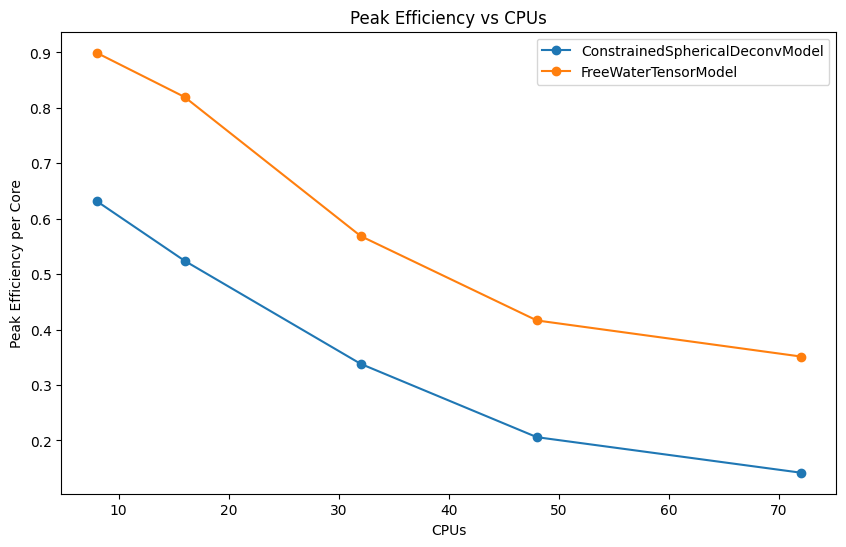

In [56]:
import matplotlib.pyplot as plt

# Get unique models
models = final_df['model'].unique()


# Create a new figure
plt.figure(figsize=(10, 6))

# For each model, plot cpus vs efficiency
for model in models:
    model_df = final_df[final_df['model'] == model]
    model_df.sort_values(by='cpus', inplace=True)
    plt.plot(model_df['cpus'], model_df['efficency'], marker='o', label=model)

# Add labels and legend
plt.xlabel('CPUs')
plt.ylabel('Peak Efficiency per Core')
plt.title('Peak Efficiency vs CPUs')
plt.legend()

# Show the plot
plt.show()